# Replicating [Simple Black-box Adversarial Attacks](https://arxiv.org/pdf/1905.07121.pdf)

This notebook uses the replicate of the Simple Black-box Adversarial attack proposed by Guo et al. [More explanation]

In [1]:
# necessary imports
# pylint: disable-msg=C0114,C0413,E0401,W0621,W0511

import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from imagenet import ImageNetDataSet
from simple_blackbox_attack.cartesian_set import CartesianSearchVectors
from simple_blackbox_attack.dct_set import DCTSearchVectors
from simple_blackbox_attack.simba import simba

Folder of the ImageNet ILSVRC2012 validation dataset, its labels in the meta data. Note: After accessing [login-access to the ImagNet website](https://image-net.org/signup.php), go to the [ImageNet 2012 version](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) and download
* Development kit (Task 1 & 2). 2.5MB. - containing the labels and the meta data
* Validation images (all tasks). 6.3GB. - the validation images

Extract both and assign the locations of the folder and files to the corresponding Constants:

In [2]:
IMAGE_FOLDER = "../../../data/val"
LABEL_FILE = "../../../data/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../data/ILSVRC2012_devkit_t12/data/meta.mat"

Let's get the data.

In [3]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, meta_file=META_FILE, transform=preprocess)

And let's see if everything worked out as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


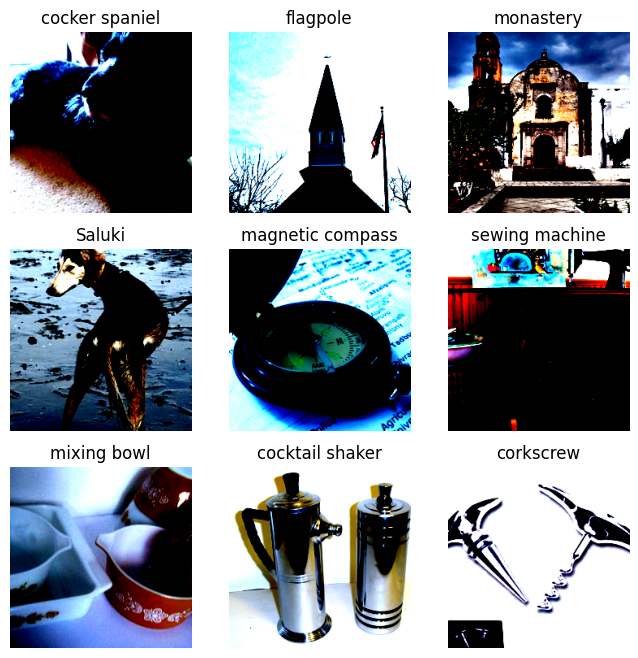

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.meta.loc[label, "label_str"])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Classifying with pre-trained ResNet50

In [5]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True)
model.eval()

for _ in range(5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 3)
    print(f"The actual label is {int(label)}")
    print(f"the model thinks it is {predictions} with probability {probs}")
    if int(label) == predictions[0]:
        print("Correct prediction! Proceeding with this image.")
        image = img
        break

The actual label is 988
the model thinks it is tensor([988, 952, 944]) with probability tensor([9.6520e-01, 3.3451e-02, 2.9948e-04])
Correct prediction! Proceeding with this image.


Using cache found in /home/eko/.cache/torch/hub/pytorch_vision_v0.10.0
/home/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-tJdzEUmr-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-tJdzEUmr-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Adversarial Attack

Let's define a simple basis first.

In [6]:
basis = CartesianSearchVectors(image.size())

And find pertubation for the example image.

In [7]:
pertubation = simba(model, image, int(label), basis, step_size=10)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

tensor([0.9652], grad_fn=<TopkBackward0>)
tensor([0.9646], grad_fn=<TopkBackward0>)
tensor([0.9626], grad_fn=<TopkBackward0>)
tensor([0.9541], grad_fn=<TopkBackward0>)
tensor([0.9514], grad_fn=<TopkBackward0>)
tensor([0.9018], grad_fn=<TopkBackward0>)
tensor([0.8921], grad_fn=<TopkBackward0>)
tensor([0.8882], grad_fn=<TopkBackward0>)
tensor([0.8827], grad_fn=<TopkBackward0>)
tensor([0.8659], grad_fn=<TopkBackward0>)
tensor([0.8638], grad_fn=<TopkBackward0>)
tensor([0.8609], grad_fn=<TopkBackward0>)
tensor([0.8296], grad_fn=<TopkBackward0>)
tensor([0.8255], grad_fn=<TopkBackward0>)
tensor([0.8075], grad_fn=<TopkBackward0>)
tensor([0.7930], grad_fn=<TopkBackward0>)
tensor([0.7837], grad_fn=<TopkBackward0>)
tensor([0.7594], grad_fn=<TopkBackward0>)
tensor([0.7347], grad_fn=<TopkBackward0>)
tensor([0.7344], grad_fn=<TopkBackward0>)
tensor([0.7165], grad_fn=<TopkBackward0>)
tensor([0.6549], grad_fn=<TopkBackward0>)
tensor([0.6537], grad_fn=<TopkBackward0>)
tensor([0.6505], grad_fn=<TopkBack

Let's plot the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


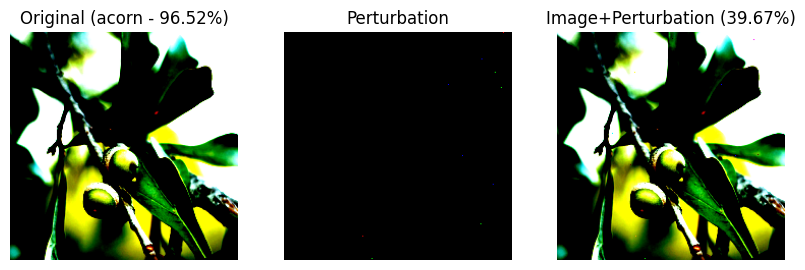

In [8]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original ({dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%)")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0))
figure.add_subplot(1, 3, 2)
plt.title("Perturbation")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0))
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%)")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0))
plt.show()

## DCT Basis

In [9]:
basis = DCTSearchVectors(image.size(), 0.5)
pertubation = simba(model, image, int(label), basis, step_size=10)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

tensor([0.9652], grad_fn=<TopkBackward0>)
tensor([0.9477], grad_fn=<TopkBackward0>)
tensor([0.9465], grad_fn=<TopkBackward0>)
tensor([0.9330], grad_fn=<TopkBackward0>)
tensor([0.9208], grad_fn=<TopkBackward0>)
tensor([0.9172], grad_fn=<TopkBackward0>)
tensor([0.9168], grad_fn=<TopkBackward0>)
tensor([0.8943], grad_fn=<TopkBackward0>)
tensor([0.8908], grad_fn=<TopkBackward0>)
tensor([0.8808], grad_fn=<TopkBackward0>)
tensor([0.8730], grad_fn=<TopkBackward0>)
tensor([0.8448], grad_fn=<TopkBackward0>)
tensor([0.8212], grad_fn=<TopkBackward0>)
tensor([0.7988], grad_fn=<TopkBackward0>)
tensor([0.7529], grad_fn=<TopkBackward0>)
tensor([0.7364], grad_fn=<TopkBackward0>)
tensor([0.7316], grad_fn=<TopkBackward0>)
tensor([0.6936], grad_fn=<TopkBackward0>)
tensor([0.6475], grad_fn=<TopkBackward0>)
tensor([0.6238], grad_fn=<TopkBackward0>)
tensor([0.5411], grad_fn=<TopkBackward0>)
tensor([0.5196], grad_fn=<TopkBackward0>)


Let's plot the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


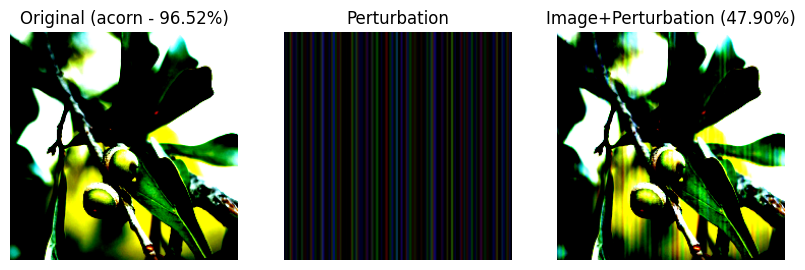

In [10]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original ({dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%)")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0))
figure.add_subplot(1, 3, 2)
plt.title("Perturbation")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0))
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%)")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0))
plt.show()